In [86]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

import argparse
import sys
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import (read_classes, read_anchors, generate_colors, preprocess_image, 
draw_boxes, scale_boxes,yolo_filter_boxes, iou, yolo_non_max_suppression, yolo_eval)
from yad2k.yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio
import sys
import argparse
from PIL import Image
from time import sleep

%matplotlib inline

In [79]:
def transformImage(path, min_size=608):
    im = Image.open(path)
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), (0, 0, 0))
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    new_im.save('output/transformed/'+path[16:-4] + '_transformed.jpg')
    
def getFirstFrame(videofile):
    vidcap = cv2.VideoCapture(videofile)
    success, image = vidcap.read()
    if success:
        cv2.imwrite("first_frame.jpg", image)  # save frame as JPEG file
        
def getCentroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)
    cx = x + x1
    cy = y + y1
    return cx,cy

def line_config(img,positionx, ylower=-1, yupper=-1):
    shape_img = img.shape
    if ylower == -1:
        ylower = 0
    if yupper == -1:
        yupper = shape_img[0]
    if positionx >= shape_img[1]:
        cv2.line(img, (ylower,shape_img[1]),(yupper,shape_img[1]),(255,127,0), 3)
    elif positionx <= 0:
        cv2.line(img, (ylower,0),(yupper,0),(255,127,0), 3)
    else:
        cv2.line(img, (ylower,positionx),(yupper, positionx),(255,127,0), 3)
    plt.imshow(img)

In [66]:
def predict(sess, img, max_boxes = 1, score_threshold=.01, iou_threshold=.01):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    # Load image size
    input_image = imageio.imread(img)
    shape = (float(input_image.shape[0]), float(input_image.shape[1]))
    
    ## outputs
    scores, boxes, classes = yolo_eval(yolo_outputs, shape, max_boxes=max_boxes,
                                       score_threshold=score_threshold,iou_threshold=iou_threshold)

    # Preprocess your image
    image, image_data = preprocess_image(img, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores, boxes, classes],
                                                 feed_dict={yolo_model.input: image_data,
                                                           K.learning_phase(): 0})
    # Filter by desirerd classes
    indexes = []
    index = 0
    for cl in [class_names[i] for i in out_classes]:
        if cl in [class_names[i] for i in [1,2,3,5,7]]:
            indexes.append(index)
        index += 1
        
    out_scores = np.array([out_scores[i] for i in indexes])
    out_boxes = np.array([out_boxes[i] for i in indexes])
    out_classes = np.array([out_classes[i] for i in indexes])


    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image.save('output/predicted/'+ img[19:-4]+ '_predicted.png', quality=90)
    # Display the results in the notebook
    output_image = imageio.imread('output/predicted/'+ img[19:-4]+ '_predicted.png')
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

### Configure line position

In [76]:
getFirstFrame('input/video.mp4')
frame = cv2.imread('first_frame.jpg')

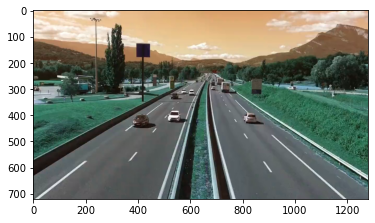

In [77]:
plt.imshow(frame)

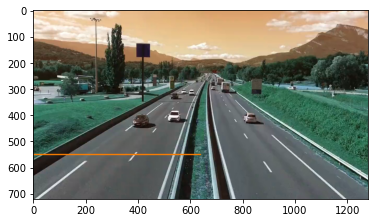

In [80]:
line_config(frame.copy(), 550,yupper = int(frame.shape[1]/2))

### Extract vehicles from video

We use OpenCV to difference the frames in the video and draw bounding boxes over each moving vehicle. Then we find the center of each box and track it. When it passes the line indicated we extract the vehicle image.

In [85]:
def getVehicles(video, positionx, lmin=frame.shape[0]/100, hmin=frame.shape[0]/100,
               fps=60, xlow=0,xhigh=int(frame.shape[1])):
    
    length_min=lmin #minimum length of boxes
    height_min=hmin #minimum height of boxes

    delay= fps #FPS

    vehicles = []
    bounds = []
    cars= 0


    frame = cv2.imread('first_frame.jpg')

    xlow = xlow #0
    xhigh = xhigh #frame.shape[1]
    offset= int(frame.shape[0]/120) #error permited per pixel

    cap = cv2.VideoCapture(video)
    subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()

    count=0
    while True:
        ret , frame1 = cap.read()
        if ret:
            tempo = float(1/delay)
            sleep(tempo) 
            grey = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(grey,(3,3),5)
            img_sub = subtractor.apply(blur)
            dilat = cv2.dilate(img_sub,np.ones((5,5)))
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            dillated = cv2.morphologyEx (dilat, cv2. MORPH_CLOSE , kernel)
            dillated = cv2.morphologyEx (dillated, cv2. MORPH_CLOSE , kernel)
            _,contours,h=cv2.findContours(dillated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            frame2 = frame1.copy()
            cv2.line(frame1, (xlow, positionx), (xhigh, positionx), (255,127,0), 3) 
            for(_,c) in enumerate(contours):
                (x,y,w,h) = cv2.boundingRect(c)
                valid_contours = (w >= length_min) and (h >= height_min)
                if not valid_contours:
                    continue

                cv2.rectangle(frame1,(x,y),(x+w,y+h),(0,255,0),2)        
                center = getCentroid(x, y, w, h)
                vehicles.append(center)
                bounds.append((x,y,x+w,y+h))
                cv2.circle(frame1, center, 4, (0, 0,255), -1)

                for (x,y) in vehicles:
                    if y<(positionx+offset) and y>(positionx-offset) and x>=xlow and x<=xhigh:
                        cars+=1
                        i = vehicles.index((x,y))
                        box= bounds[i]
                        x1 = box[1]-10
                        if x1 <0:
                            x1 = 0
                        x2 = box[3] + 10
                        if x2 > frame.shape[0]:
                            x2 = frame.shape[0]
                        y1 = box[0] - 10
                        if y1 <0:
                            y1 = 0
                        y2 = box[2] + 10
                        if y2 > frame.shape[1]:
                            y2 = frame.shape[1]
                        cv2.imshow("Detected",frame2[x1:x2, y1:y2])
                        cv2.imwrite( 'output/vehicles/' + "\\frame%d.jpg" % count, frame2[x1:x2, y1:y2])
                        count = count + 1
                        cv2.line(frame1, (xlow, positionx), (xhigh, positionx), (0,127,255), 3) 
                        vehicles.remove((x,y))
                        bounds.pop(i)

            cv2.putText(frame1, "Vehicle Count : "+str(cars), (450, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255),5)
            cv2.imshow("Video " , frame1)
            cv2.imshow("Dillated",dillated)

            if cv2.waitKey(1) == 27:
                break
        else:
            break
    cv2.destroyAllWindows()
    cap.release()


In [88]:
getVehicles('input/video.mp4', 550, lmin=80, hmin=80,
               xhigh=int(frame.shape[1]/2))

### Model

We first load YOLOv2 along with its class_names and anchors.

In [89]:
def loadModel():
    sess = K.get_session()
    class_names = read_classes("model/coco_classes.txt")
    anchors = read_anchors("model/yolo_anchors.txt")
    yolo_model = load_model("model/yolo.h5")
    yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
    yolo_outputs = (yolo_outputs[2],yolo_outputs[0], yolo_outputs[1], yolo_outputs[3])

In [90]:
loadModel()

#### Single Vehicle

Lets first see the process for a single vehicle

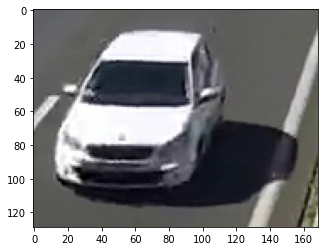

In [111]:
frame0 = imageio.imread('output/vehicles/frame1.jpg')
plt.imshow(frame0)

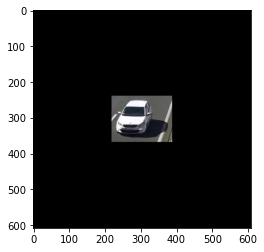

In [112]:
transformImage('output/vehicles/frame0.jpg')
frame0 = imageio.imread('output/transformed/frame1_transformed.jpg')
plt.imshow(frame0)

(array([0.81216824], dtype=float32),
 array([[246.19615, 230.87871, 347.19644, 332.90765]], dtype=float32),
 array([2], dtype=int64))

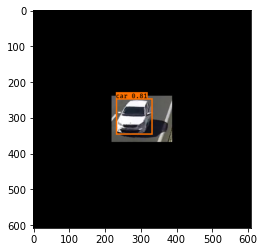

In [113]:
predict(sess, 'output/transformed/frame1_transformed.jpg', 1,0.1,0.01)

#### Now for all the vehicles

We transform each vehicle image by adding a black background and making it larger and the same size that our model accepts so its easier for YOLO to find the proper bounding boxes and classify each vehicle. Then our model predicts the class of each vehicle and returns the classes predicted.

In [93]:
def transformPredict(lanes=1, core_threshold=.2):
    images = [img for img in os.listdir("output/vehicles/") if img.endswith(".jpg")]
    images = pd.Series(images).str.replace('frame','').str.replace('.jpg', '').astype(int)
    images = ('frame' + pd.Series(np.sort(images)).astype(str) + '.jpg').tolist()


    counter = []
    for img in images:
        transformImage('output/vehicles/'+img)
        _, _, out_classes = predict(sess, 'output/transformed/'+img[:-4] + '_transformed.jpg', lanes,core_threshold,0.01)
        counter.append(out_classes)
        
    return counter

C:\Users\giwef\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


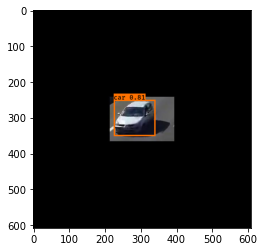

In [94]:
counter = transformPredict(lanes=2)

Using the classes from the previous step, we now create a dictionary to store the number of vehicles of each class found.

In [105]:
def finaliseCounter(counter):
    final_counter = {
        'car':0,
        'motorbike':0,
        'truck':0,
        'bus':0,
        'bicycle':0
    }
    for c in counter:
        for i in range(len(c)):
            res = class_names[c[i]]
            final_counter[res]+=1
                
    return final_counter

In [106]:
final_counter = finaliseCounter(counter)
final_counter

{'car': 97, 'motorbike': 1, 'truck': 8, 'bus': 0, 'bicycle': 0}